# Notebook for building cages from Andrew Marsh precursors

Distributed under the terms of the MIT License.

Author: Andrew Tarzia

Date Created: 22 Feb 2019


In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
import glob
import stk
import pywindow as pw
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
precursor_dir = '/home/atarzia/projects/andrew_marsh_structures/precursor_lib/'
output_dir = '/home/atarzia/projects/andrew_marsh_structures/output/'
macromod_ = '/home/atarzia/software/schrodinger_install'
# '/rds/general/user/fszczypi/home/schrodinger2018-4'
big_DB = '/data/atarzia/precursor_DBs/reaxys_sorted/'
aldehydes2f = big_DB+'aldehydes2f/'
print(len(glob.glob(aldehydes2f+'*mol')), 'precusrors in', aldehydes2f)
aldehydes3f = big_DB+'aldehydes3f/'
print(len(glob.glob(aldehydes3f+'*mol')), 'precusrors in', aldehydes3f)
amines2f = big_DB+'amines2f/'
print(len(glob.glob(amines2f+'*mol')), 'precusrors in', amines2f)
amines3f = big_DB+'amines3f/'
print(len(glob.glob(amines3f+'*mol')), 'precusrors in', amines3f)

280 precusrors in /data/atarzia/precursor_DBs/reaxys_sorted/aldehydes2f/
63 precusrors in /data/atarzia/precursor_DBs/reaxys_sorted/aldehydes3f/
507 precusrors in /data/atarzia/precursor_DBs/reaxys_sorted/amines2f/
90 precusrors in /data/atarzia/precursor_DBs/reaxys_sorted/amines3f/


In [3]:
# synthetic accessibility DBs
amines2f_SA = pd.read_csv(amines2f+'score_output_amines2f.csv')
amines3f_SA = pd.read_csv(amines3f+'score_output_amines3f.csv')

In [4]:
precursor_files = sorted(glob.glob(precursor_dir+'*.mol'))
precursor_names = [i.replace(precursor_dir, '') for i in precursor_files]
precursor_struc = [stk.StructUnit3(i) for i in precursor_files]  # read in mol files

## Aldehyde 1

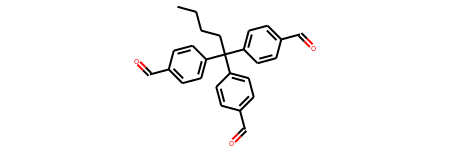

In [5]:
Chem.MolFromInchi(precursor_struc[0].inchi)

## Aldehyde 2

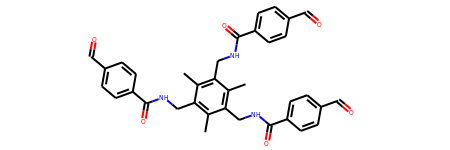

In [6]:
Chem.MolFromInchi(precursor_struc[1].inchi)

## Aldehyde 3

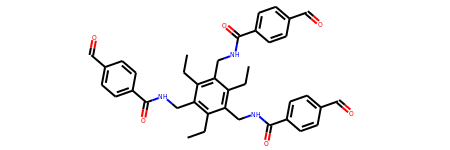

In [7]:
Chem.MolFromInchi(precursor_struc[2].inchi)

## Aldehyde 4

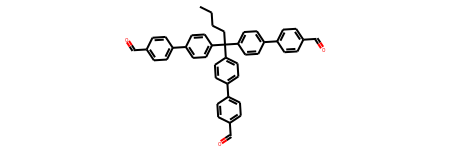

In [8]:
Chem.MolFromInchi(precursor_struc[3].inchi)

### Filip Example

In [11]:
# Import building blocks - use some examples from steven DB

bb3 = stk.StructUnit3(precursor_dir+'aldehyde1.mol')
bb2 = stk.StructUnit2(amines2f+'amine2f_13.mol')

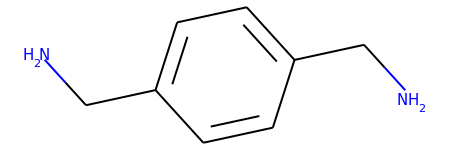

In [12]:
Chem.MolFromInchi(bb2.inchi)

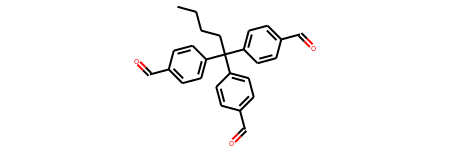

In [13]:
Chem.MolFromInchi(bb3.inchi)

In [14]:
# Assemble trigonal prism cage (six amine3 + nine ald2)

cage = stk.Cage([bb3,bb2], stk.FourPlusSix())
cage.write(output_dir+'cage_test.mol')

In [15]:
cage.bb_distortion()

0.00010554352552896498

In [18]:
macromod_

'/home/atarzia/software/schrodinger_install'

In [17]:
# MacroModel optimisation (OPLS3)

stk.macromodel_opt(cage, macromodel_path=macromod_)
cage.write(output_dir+'cage_test_opt.mol')

In [19]:
print(cage.window_difference())

0.4326894464998441


In [21]:
# Import optimised cage into pyWindow, via RDkit mol file

cage_rd = Chem.MolFromMolFile(output_dir+'cage_test_opt.mol')
cage_sys = pw.MolecularSystem.load_rdkit_mol(cage_rd)
cage_mol = cage_sys.system_to_molecule()

In [22]:
# Perform full pyWindow analysis

cage_mol.full_analysis()

# Dump pyWindow properties into JSON and cage into xyz

cage_mol.dump_properties_json(output_dir+'cage_test_opt_mol_properties.json')
cage_mol.dump_molecule(output_dir+'cage_test_opt_pyWindowOut.xyz')

In [18]:
# #!/bin/bash

# #PBS -N mmod_moldyn_MegaCage_1500K_15ns_5000struct
# #PBS -j oe
# #PBS -o PBS-output.txt
# #PBS -l walltime=24:00:00
# #PBS -l select=1:ncpus=1:mem=64gb

# export SCHRODINGER=/rds/general/user/fszczypi/home/schrodinger2018-4

# cd $TMPDIR
# cp $PBS_O_WORKDIR/* $TMPDIR

# $SCHRODINGER/bmin -WAIT -LOCAL ${PBS_O_WORKDIR##*/}

# cp $TMPDIR/. $PBS_O_WORKDIR -r

# Brute force production of cages
- for all 4 precursors
- all possible topologies (3aldehdye+2amine)
- all possible topologies (3aldehdye+3amine)
- macromodel optimization will determine if collapsed
- run full pywindow analysis
    - output properties
- read pywindow results
    - produce CSV: BB-aldehyde, BB-amine, collapsed?, ....

In [9]:
def is_collapse(topo, avg_diff, max_window_diam, cavity_size, no_window):
    e_wind = {'dodec': 12, '4p6': 4, '4p62': 4,
              '8p12': 6,  '6p9': 5, '2p3': 3, 
              '4p4': 6, '1p1': 3, '2p2': 4}
    expected_wind = e_wind[topo]
    if expected_wind == no_window:
        alpha = 4 * avg_diff / (max_window_diam * expected_wind)
        if alpha < 0.035 and cavity_size > 1:
            # not collapsed
            return False
        else:
            # unknown
            return None
    else:
        # collapsed
        return True
    

def get_assymmetry(data):
    """Calculate assymetry as defined in GA paper (Berardo)
    
    The sum of all the windows' pair differences represents the asymmetry of the individual, Asymmetry parameter in eqn (1)
    """
    window_sizes = data['windows']['diameters']
    total = 0
    for i, a in enumerate(window_sizes):
        for j, b in enumerate(window_sizes[i:]):
            if i != j+i:
#                 print(i, j, j+i)
#                 print(a, b)
                diff = abs(a - b)
                total += diff
    return total   

In [10]:
from stk.molecular.molecules import MacroMoleculeBuildError

In [11]:
# prepare output file
if input('wipe??') == 't':
    with open(output_dir+'full_output.csv', 'w') as f:
        f.write('name,bb1,SA1,bb2,SA2,topo,max_diam,p_diam,p_vol,p_diam_opt,p_vol_opt,w_no,w_max,w_min,w_avg,w_diff,collapse,assym\n')

wipe?? 


In [ ]:
# diamines (alde3+amine2)
topology_names = ['2p3', '4p6', '4p62', '6p9'] #'dodec', '8p12',  ]
topology_options = [stk.two_plus_three.TwoPlusThree(), stk.two_plus_three.FourPlusSix(), stk.two_plus_three.FourPlusSix2(), stk.two_plus_three.SixPlusNine()]
                    # , stk.two_plus_three.Dodecahedron(), stk.two_plus_three.EightPlusTwelve(),]
DB = amines2f
amines = glob.glob(DB+'*.mol')

for i, prec in enumerate(precursor_struc):
    print('doing:', precursor_files[i])
    for j, amine in enumerate(amines):
        bb_amine = stk.StructUnit2(amine)
        for k, topo in enumerate(topology_options):
            # naming convention: aldehyde-name_amine-name_topology
            # amine-name: amineDB_NO
            NAME = precursor_names[i].replace('.mol', '')
            NAME += '_'+amine.replace('.mol', '').replace(DB, '')+'_'
            NAME += topology_names[k]
            prop_file = output_dir+NAME+'_opt_properties.json'
            mole_file = output_dir+NAME+'_opt_PWout.xyz'
            if os.path.isfile(output_dir+NAME+'_opt.mol') is False:
#                 print(NAME)
                try:
                    cage = stk.Cage([prec, bb_amine], topo)
                    cage.write(output_dir+NAME+'.mol')
                    stk.macromodel_opt(cage, macromodel_path=macromod_, 
                                       settings={'restricted': False,
                                                 'timeout': None,
                                                 'force_field': 16,
                                                 'max_iter': 2500,
                                                 'gradient': 0.05,
                                                 'md': True
                                                },
                                       md={'timeout': None,
                                           'force_field': 16,
                                           'temp': 700,
                                           'confs': 50,
                                           'time_step': 1.0,
                                           'eq_time': 10,
                                           'sim_time': 200,
                                           'max_iter': 2500,
                                           'gradient': 0.05
                                          })
                    cage.write(output_dir+NAME+'_opt.mol')
                    prop_file = output_dir+NAME+'_opt_properties.json'
                    mole_file = output_dir+NAME+'_opt_PWout.xyz'
                    # check if completed
                    if os.path.isfile(prop_file) is False:
                        # Import optimised cage into pyWindow, via RDkit mol file
                        cage_rd = Chem.MolFromMolFile(output_dir+NAME+'_opt.mol')
                        cage_sys = pw.MolecularSystem.load_rdkit_mol(cage_rd)
                        cage_mol = cage_sys.system_to_molecule()
                        # Perform full pyWindow analysis
                        cage_mol.full_analysis()
                        # Dump pyWindow properties into JSON and cage into xyz
                        cage_mol.dump_properties_json(prop_file)
                        cage_mol.dump_molecule(mole_file, include_coms=True)    
                except MacroMoleculeBuildError:
                    pass
                if os.path.isfile(prop_file) is True:
                    # all analysis done successfully -- output
                    bb1, SA1, bb2, SA2, topo = '-', '-', '-', '-', '-'
                    max_diam, p_diam, p_vol = '-', '-', '-'
                    p_diam_opt, p_vol_opt = '-', '-'
                    w_no, w_max, w_min, w_avg = '-', '-', '-', '-'
                    w_diff, collapsed, assymetry = '-', '-', '-'
                    with open(prop_file, 'r') as f:
                        data = json.load(f)
                    bb1 = NAME.split('_')[0]
                    bb2 = '_'.join(NAME.split('_')[1:3])
                    topo = NAME.split('_')[3]
                    max_diam = str(data['maximum_diameter']['diameter'])
                    p_diam = str(data['pore_diameter']['diameter'])
                    p_diam_opt = str(data['pore_diameter_opt']['diameter'])
                    p_vol = str(data['pore_volume'])
                    p_vol_opt = str(data['pore_volume_opt'])
                    if data['windows']['diameters'] is None:
                        w_no, w_max, w_min, w_avg, w_diff = '0', '0', '0', '0', '0'
                        collapse = '2'  # unsure
                        assymetry = '-2'
                    elif len(data['windows']['diameters']) == 0:
                        w_no, w_max, w_min, w_avg, w_diff = '0', '0', '0', '0', '0'
                        collapse = '1'  # collapsed
                        assymetry = '-2'
                    else:
                        if max(data['windows']['diameters']) < 200:
                            w_no = str(len(data['windows']['diameters']))
                            w_max = str(max(data['windows']['diameters']))
                            w_min = str(min(data['windows']['diameters']))
                            w_avg = str(np.average(data['windows']['diameters']))
                            if topo != '4p62':
                                w_diff = str(cage.window_difference())
                            else:
                                w_diff = None
                            if w_diff is None:
                                w_diff = '-5'
                            assymetry = str(get_assymmetry(data))
                            coll_flag = is_collapse(topo=topo, avg_diff=w_diff, max_window_diam=w_max, 
                                                    cavity_size=cage.cavity_size(), no_window=w_no)
                            if coll_flag is True:
                                collapse = '0'
                            elif coll_flag is False:
                                collapse = '1'
                            elif coll_flag is None:
                                collapse = '2'
                        else:
                            w_no, w_max, w_min, w_avg, w_diff = '-1', '-1', '-1', '-1', '-1'
                            collapse = '2'  # unsure
                            assymetry = '-1'
                    with open(output_dir+'full_output.csv', 'a') as f:
                        f.write(NAME+','+bb1+','+SA1+','+bb2+','+SA2+','+topo+',')
                        f.write(max_diam+','+p_diam+','+p_vol+','+p_diam_opt+',')
                        f.write(p_vol_opt+','+w_no+','+w_max+','+w_min+','+w_avg+',')
                        f.write(w_diff+','+collapse+','+assymetry)
                        f.write('\n')

doing: /home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde1.mol
doing: /home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde2.mol


In [ ]:
# Check that the number output files matches the expected number based on inputs
print(len(glob.glob(precursor_dir+'*mol')), 'precusrors in', precursor_dir)
print(len(glob.glob(amines2f+'*mol')), 'precusrors in', amines2f)
print(len(topology_options), 'possible topologies per cage')
n_cages = len(glob.glob(precursor_dir+'*mol')) * len(glob.glob(amines2f+'*mol')) * len(topology_options)
print('>>', n_cages, 'cages')
print(len(glob.glob(output_dir+'*amine2f*_opt*mol')), 'cages optimized')

In [78]:
# triamines (alde3+amine3)
topology_names = ['1p1', '4p4', '2p2']
topology_options = [stk.three_plus_three.OnePlusOne(bb_assignments={0: [], 1: []}), 
                    stk.three_plus_three.FourPlusFour(bb_assignments={0: [], 1: []}), 
                    stk.three_plus_three.TwoPlusTwo(bb_assignments={0: [], 1: []})]
DB = amines3f
amines = glob.glob(DB+'*.mol')

for i, prec in enumerate(precursor_struc):
    print('doing:', precursor_files[i])
    for j, amine in enumerate(amines):
        bb_amine = stk.StructUnit3(amine)
        for k, topo in enumerate(topology_options):
            # naming convention: aldehyde-name_amine-name_topology
            # amine-name: amineDB_NO
            NAME = precursor_names[i].replace('.mol', '')
            NAME += '_'+amine.replace('.mol', '').replace(DB, '')+'_'
            NAME += topology_names[k]
            prop_file = output_dir+NAME+'_opt_properties.json'
            mole_file = output_dir+NAME+'_opt_PWout.xyz'
            if os.path.isfile(output_dir+NAME+'_opt.mol') is False:
#                 print(NAME)
                try:
                    cage = stk.Cage([prec, bb_amine], topo)
                    cage.write(output_dir+NAME+'.mol')
                    stk.macromodel_opt(cage, macromodel_path=macromod_, 
                                       settings={'restricted': False,
                                                 'timeout': None,
                                                 'force_field': 16,
                                                 'max_iter': 2500,
                                                 'gradient': 0.05,
                                                 'md': True
                                                },
                                       md={'timeout': None,
                                           'force_field': 16,
                                           'temp': 700,
                                           'confs': 50,
                                           'time_step': 1.0,
                                           'eq_time': 10,
                                           'sim_time': 200,
                                           'max_iter': 2500,
                                           'gradient': 0.05
                                          })
                    cage.write(output_dir+NAME+'_opt.mol')
                    # check if completed
                    if os.path.isfile(prop_file) is False:
                        # Import optimised cage into pyWindow, via RDkit mol file
                        cage_rd = Chem.MolFromMolFile(output_dir+NAME+'_opt.mol')
                        cage_sys = pw.MolecularSystem.load_rdkit_mol(cage_rd)
                        cage_mol = cage_sys.system_to_molecule()
                        # Perform full pyWindow analysis
                        cage_mol.full_analysis()
                        # Dump pyWindow properties into JSON and cage into xyz
                        cage_mol.dump_properties_json(prop_file)
                        cage_mol.dump_molecule(mole_file, include_coms=True)    
                except MacroMoleculeBuildError:
                    pass
                if os.path.isfile(prop_file) is True:
                    # all analysis done successfully -- output
                    bb1, SA1, bb2, SA2, topo = '-', '-', '-', '-', '-'
                    max_diam, p_diam, p_vol = '-', '-', '-'
                    p_diam_opt, p_vol_opt = '-', '-'
                    w_no, w_max, w_min, w_avg = '-', '-', '-', '-'
                    w_diff, collapsed, assymetry = '-', '-', '-'
                    with open(prop_file, 'r') as f:
                        data = json.load(f)
                    bb1 = NAME.split('_')[0]
                    bb2 = '_'.join(NAME.split('_')[1:3])
                    topo = NAME.split('_')[3]
                    max_diam = str(data['maximum_diameter']['diameter'])
                    p_diam = str(data['pore_diameter']['diameter'])
                    p_diam_opt = str(data['pore_diameter_opt']['diameter'])
                    p_vol = str(data['pore_volume'])
                    p_vol_opt = str(data['pore_volume_opt'])
                    if data['windows']['diameters'] is None:
                        w_no, w_max, w_min, w_avg, w_diff = '0', '0', '0', '0', '0'
                        collapse = '2'  # unsure
                        assymetry = '-2'
                    elif len(data['windows']['diameters']) == 0:
                        w_no, w_max, w_min, w_avg, w_diff = '0', '0', '0', '0', '0'
                        collapse = '1'  # collapsed
                        assymetry = '-2'
                    else:
                        if max(data['windows']['diameters']) < 200:
                            w_no = str(len(data['windows']['diameters']))
                            w_max = str(max(data['windows']['diameters']))
                            w_min = str(min(data['windows']['diameters']))
                            w_avg = str(np.average(data['windows']['diameters']))
                            w_diff = str(cage.window_difference())
                            if w_diff is None:
                                w_diff = '-5'
                            assymetry = str(get_assymmetry(data))
                            coll_flag = is_collapse(topo=topo, avg_diff=w_diff, max_window_diam=w_max, 
                                                    cavity_size=cage.cavity_size(), no_window=w_no)
                            if coll_flag is True:
                                collapse = '0'
                            elif coll_flag is False:
                                collapse = '1'
                            elif coll_flag is None:
                                collapse = '2'
                        else:
                            w_no, w_max, w_min, w_avg, w_diff = '-1', '-1', '-1', '-1', '-1'
                            collapse = '2'  # unsure
                            assymetry = '-1'
                    with open(output_dir+'full_output.csv', 'a') as f:
                        f.write(NAME+','+bb1+','+SA1+','+bb2+','+SA2+','+topo+',')
                        f.write(max_diam+','+p_diam+','+p_vol+','+p_diam_opt+',')
                        f.write(p_vol_opt+','+w_no+','+w_max+','+w_min+','+w_avg+',')
                        f.write(w_diff+','+collapse+','+assymetry)
                        f.write('\n')

doing: /home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde1.mol
doing: /home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde2.mol
doing: /home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde3.mol
doing: /home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde4.mol


# Testing position placement of BBs

#### amine 3

In [13]:
# triamines (alde3+amine3)
topology_names = ['1p1', '4p4'] #, '2p2']
topology_options = [stk.three_plus_three.OnePlusOne(bb_positions={0: [0], 1: [1]}), # place bb1 on vertex (0), bb2 on vertex (1)
                    stk.three_plus_three.FourPlusFour(bb_positions={0: [0, 3, 5, 6], 1: [1, 2, 4, 7]}), # place bb1 on vertex (0, 2), bb2 on vertex (1, 3)
                   ]#stk.three_plus_three.TwoPlusTwo(bb_positions={0: [0, 2], 1: [1, 3]})] # place bb1 on vertex (0, 2), bb2 on vertex (1, 3)
DB = amines3f
amines = glob.glob(DB+'*.mol')

In [14]:
for i, prec in enumerate(precursor_struc):
    print('doing:', precursor_files[i])
    for j, amine in enumerate(amines):
        bb_amine = stk.StructUnit3(amine)
        for k, topo in enumerate(topology_options):
            # naming convention: aldehyde-name_amine-name_topology
            # amine-name: amineDB_NO
            NAME = precursor_names[i].replace('.mol', '')
            NAME += '_'+amine.replace('.mol', '').replace(DB, '')+'_'
            NAME += topology_names[k]
            cage = stk.Cage([prec, bb_amine], topo)
#             cage.write(output_dir+NAME+'_test.mol')
        break
    break

doing: /home/atarzia/projects/andrew_marsh_structures/precursor_lib/aldehyde1.mol


In [15]:
NAME

'aldehyde1_amine3f_236_4p4'

In [83]:
new_cage = stk.StructUnit(output_dir+NAME+'_opt.mol')

In [85]:
new_cage.energy.macromodel(16, macromod_)

3238.7947

In [98]:
for i in new_cage.energy.values:
    print(i)
    print(new_cage.energy.values[i])

FunctionData('macromodel', forcefield=16, conformer=-1)
3238.7947


In [86]:
new_cage.energy.macromodel?

In [16]:
cage

Cage(building_blocks=["StructUnit3 ['aldehyde', 'InChI=1S/C26H24O3/c1-2-3-16-26(23-10-4-20(17-27)5-11-23,24-12-6-21(18-28)7-13-24)25-14-8-22(19-29)9-15-25/h4-15,17-19H,2-3,16H2,1H3']", "StructUnit3 ['amine', 'InChI=1S/C12H25N3O7/c13-3-1-4(14)11(10(20)7(3)17)22-12-6(15)9(19)8(18)5(2-16)21-12/h3-12,16-20H,1-2,13-15H2/t3-,4-,5-,6-,7-,8-,9-,10+,11+,12-/m1/s1']"], topology=FourPlusFour(alignments=None, bb_positions={0: [0, 3, 5, 6], 1: [1, 2, 4, 7]}))

In [22]:
cage.load?

In [23]:
cage_rd = Chem.MolFromMolFile(output_dir+NAME+'_opt.mol')
cage_sys = pw.MolecularSystem.load_rdkit_mol(cage_rd)
cage_mol = cage_sys.system_to_molecule()

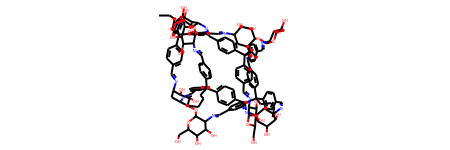

In [29]:
cage_rd

In [51]:
import copy

In [52]:
new_cage = copy.deepcopy(cage)

In [55]:
new_cage == cage

True

In [56]:
file = NAME+'_opt.mol'

In [58]:
string = open(output_dir+file, 'r').readlines()

In [61]:
new_cage.json()['mol_block']

'\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 364 388 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C -16.6367 10.3565 -17.4534 0\nM  V30 2 C -16.3985 11.7712 -17.0945 0\nM  V30 3 C -16.1368 12.7060 -18.1016 0\nM  V30 4 C -15.9077 14.0461 -17.7819 0\nM  V30 5 C -15.9429 14.4929 -16.4406 0\nM  V30 6 C -16.1938 13.5321 -15.4307 0\nM  V30 7 C -16.4217 12.1922 -15.7574 0\nM  V30 8 C -15.6686 15.9903 -16.1316 0\nM  V30 9 C -15.8761 16.3466 -14.6269 0\nM  V30 10 C -14.1989 16.2054 -16.5925 0\nM  V30 11 C -16.7143 16.8569 -16.9331 0\nM  V30 12 C -12.4904 17.2067 -18.0285 0\nM  V30 13 C -11.4881 16.4692 -17.3818 0\nM  V30 14 C -11.8409 15.5919 -16.3514 0\nM  V30 15 C -13.1757 15.4561 -15.9655 0\nM  V30 16 C -17.1359 16.1186 -14.0227 0\nM  V30 17 C -14.8649 16.9451 -13.8356 0\nM  V30 18 C -17.3648 16.4465 -12.6848 0\nM  V30 19 C -16.3475 17.0230 -11.9124 0\nM  V30 20 C -15.1014 17.2721 -12.4975 0\nM  V30 21 C -16.5742 17.3783 -10.4950 0\nM  V30 22 C

In [60]:
''.join(string)

'\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 364 388 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C -7.1063 -0.2316 -5.6764 0\nM  V30 2 C -6.8595 1.2015 -5.4608 0\nM  V30 3 C -5.7188 1.6875 -4.8150 0\nM  V30 4 C -5.4808 3.0593 -4.7373 0\nM  V30 5 C -6.3710 3.9941 -5.2991 0\nM  V30 6 C -7.5449 3.4918 -5.8869 0\nM  V30 7 C -7.7799 2.1234 -5.9694 0\nM  V30 8 C -6.0131 5.5260 -5.3110 0\nM  V30 9 C -6.2341 6.1826 -3.9063 0\nM  V30 10 C -4.5083 5.6257 -5.7482 0\nM  V30 11 C -6.9393 6.2909 -6.3406 0\nM  V30 12 C -2.7849 5.5847 -7.4692 0\nM  V30 13 C -1.7784 5.6960 -6.5024 0\nM  V30 14 C -2.1518 5.8009 -5.1593 0\nM  V30 15 C -3.4876 5.7571 -4.7908 0\nM  V30 16 C -6.8130 5.4894 -2.8296 0\nM  V30 17 C -5.7334 7.4711 -3.6615 0\nM  V30 18 C -6.7595 6.0105 -1.5370 0\nM  V30 19 C -6.1443 7.2452 -1.2938 0\nM  V30 20 C -5.6950 7.9983 -2.3797 0\nM  V30 21 C -5.8076 7.7191 0.0516 0\nM  V30 22 C -0.3629 5.6185 -6.8896 0\nM  V30 23 C -4.1293 5.5496 -7.0983 0

In [66]:
new_cage.mol = Chem.MolFromMolBlock(''.join(string))

In [ ]:
new_cage.

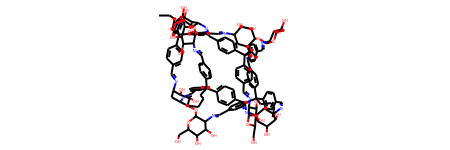

In [67]:
new_cage.mol

In [ ]:
new_cage.write # what does this function use???????

In [70]:
new_cage.energy.rdkit(forcefield='uff')

462.74202698676527

In [75]:
new_cage.note

<generator object Molecule.all_atom_coords at 0x7faffeb4af10>

In [72]:
new_cage.energy.macromodel(16, macromod_)

EnergyError: MacroModel energy calculation failed.

In [62]:
new_cage.json()['mol_block'] = ''.join(string)

In [63]:
new_cage == cage

True

In [64]:
new_cage.json()['mol_block']

'\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 364 388 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C -16.6367 10.3565 -17.4534 0\nM  V30 2 C -16.3985 11.7712 -17.0945 0\nM  V30 3 C -16.1368 12.7060 -18.1016 0\nM  V30 4 C -15.9077 14.0461 -17.7819 0\nM  V30 5 C -15.9429 14.4929 -16.4406 0\nM  V30 6 C -16.1938 13.5321 -15.4307 0\nM  V30 7 C -16.4217 12.1922 -15.7574 0\nM  V30 8 C -15.6686 15.9903 -16.1316 0\nM  V30 9 C -15.8761 16.3466 -14.6269 0\nM  V30 10 C -14.1989 16.2054 -16.5925 0\nM  V30 11 C -16.7143 16.8569 -16.9331 0\nM  V30 12 C -12.4904 17.2067 -18.0285 0\nM  V30 13 C -11.4881 16.4692 -17.3818 0\nM  V30 14 C -11.8409 15.5919 -16.3514 0\nM  V30 15 C -13.1757 15.4561 -15.9655 0\nM  V30 16 C -17.1359 16.1186 -14.0227 0\nM  V30 17 C -14.8649 16.9451 -13.8356 0\nM  V30 18 C -17.3648 16.4465 -12.6848 0\nM  V30 19 C -16.3475 17.0230 -11.9124 0\nM  V30 20 C -15.1014 17.2721 -12.4975 0\nM  V30 21 C -16.5742 17.3783 -10.4950 0\nM  V30 22 C

In [50]:
Chem.MolToMolBlock(cage_rd)

'\n     RDKit          3D\n\n192216  0  0  0  0  0  0  0  0999 V2000\n   -7.1063   -0.2316   -5.6764 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.8595    1.2015   -5.4608 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.7188    1.6875   -4.8150 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.4808    3.0593   -4.7373 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.3710    3.9941   -5.2991 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -7.5449    3.4918   -5.8869 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -7.7799    2.1234   -5.9694 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.0131    5.5260   -5.3110 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.2341    6.1826   -3.9063 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.5083    5.6257   -5.7482 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.9393    6.2909   -6.3406 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.7849    5.5847   -7.4692 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.7784    5.6960   -6.5024 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.1

In [46]:
cage.json().keys()

dict_keys(['bb_counter', 'bonds_made', 'class', 'mol_block', 'building_blocks', 'topology', 'unscaled_fitness', 'progress_params', 'note', 'name', 'atom_props'])

In [47]:
cage.json()['mol_block']

'\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 364 388 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C -16.6367 10.3565 -17.4534 0\nM  V30 2 C -16.3985 11.7712 -17.0945 0\nM  V30 3 C -16.1368 12.7060 -18.1016 0\nM  V30 4 C -15.9077 14.0461 -17.7819 0\nM  V30 5 C -15.9429 14.4929 -16.4406 0\nM  V30 6 C -16.1938 13.5321 -15.4307 0\nM  V30 7 C -16.4217 12.1922 -15.7574 0\nM  V30 8 C -15.6686 15.9903 -16.1316 0\nM  V30 9 C -15.8761 16.3466 -14.6269 0\nM  V30 10 C -14.1989 16.2054 -16.5925 0\nM  V30 11 C -16.7143 16.8569 -16.9331 0\nM  V30 12 C -12.4904 17.2067 -18.0285 0\nM  V30 13 C -11.4881 16.4692 -17.3818 0\nM  V30 14 C -11.8409 15.5919 -16.3514 0\nM  V30 15 C -13.1757 15.4561 -15.9655 0\nM  V30 16 C -17.1359 16.1186 -14.0227 0\nM  V30 17 C -14.8649 16.9451 -13.8356 0\nM  V30 18 C -17.3648 16.4465 -12.6848 0\nM  V30 19 C -16.3475 17.0230 -11.9124 0\nM  V30 20 C -15.1014 17.2721 -12.4975 0\nM  V30 21 C -16.5742 17.3783 -10.4950 0\nM  V30 22 C

In [41]:
cage.energy.rdkit(forcefield='uff')

RDKit ERROR: [11:58:24] UFFTYPER: Unrecognized hybridization for atom: 0
RDKit ERROR: [11:58:24] UFFTYPER: Unrecognized atom type: C_ (0)
RDKit ERROR: [11:58:24] UFFTYPER: Unrecognized hybridization for atom: 1
RDKit ERROR: [11:58:24] UFFTYPER: Unrecognized atom type: C_ (1)
RDKit ERROR: [11:58:24] UFFTYPER: Unrecognized hybridization for atom: 2
RDKit ERROR: [11:58:24] UFFTYPER: Unrecognized atom type: C_ (2)
RDKit ERROR: [11:58:24] UFFTYPER: Unrecognized hybridization for atom: 3
RDKit ERROR: [11:58:24] UFFTYPER: Unrecognized atom type: C_ (3)
RDKit ERROR: [11:58:24] UFFTYPER: Unrecognized hybridization for atom: 4
RDKit ERROR: [11:58:24] UFFTYPER: Unrecognized atom type: C_ (4)
RDKit ERROR: [11:58:24] UFFTYPER: Unrecognized hybridization for atom: 5
RDKit ERROR: [11:58:24] UFFTYPER: Unrecognized atom type: C_ (5)
RDKit ERROR: [11:58:24] UFFTYPER: Unrecognized hybridization for atom: 6
RDKit ERROR: [11:58:24] UFFTYPER: Unrecognized atom type: C_ (6)
RDKit ERROR: [11:58:24] UFFTYPER: 

14.179765282920378

In [43]:
cage.energy.values

{FunctionData('rdkit', forcefield='uff', conformer=-1): 14.179765282920378}